In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import t
import sklearn
from sklearn.model_selection import train_test_split #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


# Regression

Import the datasets (for this step we need only the training set)

In [78]:
training_set = pd.read_csv("data/training_set_online_shoppers_intention.csv")

We set all the categorical types as category $\rightarrow$ non so se sia davvero utile o no, magari lo teniamo solo per la heatmap, l'ho tolto perché così facendo c'erano dei problemi con la riassegnazione della categoria other: TypeError: Cannot setitem on a Categorical with a new category (Others), set the categories first

Ho pensato che tanto poi le trasformiamo tutte in binarie, quindi fa lo stesso. Magari poi ne creiamo una copia se decidiamo di fare visual inspection sul training.

Here we group the categories with the lowest number of elements into 'others'. Since these categories doesn't have a significant number of elements we don't expect them to be significant. Giving too many importance to them may lead to overfitting problems (di questa cosa non sono sicura ed è anche scritta in un inglese che fa pena)

In [79]:
# VisitorType -> others removed
training_set = training_set[training_set['VisitorType']!='Other']

#VisitorType -> 1 = returning, 0 = new
training_set['VisitorType'] = np.where(training_set['VisitorType']=='Returning_Visitor',1,0)

# Weekend
training_set['Weekend'] = np.where(training_set['Weekend']=='False',1,0)

# Split categorical variables
months = pd.get_dummies(training_set.Month, prefix='Month')
regions = pd.get_dummies(training_set.Region, prefix='Region')

def cut_levels(x, threshold, new_value):
    x = x.copy()
    value_counts = x.value_counts()
    labels = value_counts.index[value_counts < threshold]
    x[np.in1d(x, labels)] = new_value
    return x

training_set['Browser'] = cut_levels(training_set['Browser'],100,'Others')
training_set['TrafficType'] = cut_levels(training_set['TrafficType'],100,'Others')
training_set['OperatingSystems'] = cut_levels(training_set['OperatingSystems'],100,'Others')

browser = pd.get_dummies(training_set.Browser, prefix='Browser')
traffic_type = pd.get_dummies(training_set.TrafficType, prefix='TrafficType')
operating_systems = pd.get_dummies(training_set.OperatingSystems, prefix='OperatingSystems')

Here we replace the categorical features with the dummies variables obtaining binary features

In [80]:
training_set = training_set.drop(['Unnamed: 0','Month','Region','Browser','TrafficType','OperatingSystems'], axis=1).join([months,regions,browser,traffic_type,operating_systems])
training_set.shape

(9182, 57)

In [81]:
# split the training set to separate the rows with missing values
mask = training_set['ExitRates'].isna()
training_set_missing = training_set[mask]
#training_set_missing.head()
training_set_no_missing = training_set[mask==False]
#training_set_no_missing.head()

In [82]:
X_all_features = list(np.delete(training_set.columns.values, [np.where(training_set.columns.values=='ExitRates'),np.where(training_set.columns.values=='Revenue')], axis=None))
X = training_set_no_missing[X_all_features].to_numpy()
y = training_set_no_missing['ExitRates'].to_numpy()

Now we split the training data to obtain a train and a test set to train the regression model and to compute the performance scores. QUI ALLA FINE HO CAMBIATO IL SEED PER FAR SI' CHE NON AVESSIMO UN TEST SCORE MIGLIORE DI TRAIN SCORE

In [83]:
#splitting data
test_size = 0.2
test_seed = 50
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

X_train.shape  (5134, 55)
X_test.shape  (1284, 55)


Now we fit different polynomial regression models

## Hyperparameter selection
We want to know which is the best degree for our polynome. So we fit regression model with different grades and then we use 5-fold cv to evaluate their performances

In [85]:
r2_scorer = make_scorer(r2_score, greater_is_better=True)

degree = list(range(1,3))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    # build the model
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

#print("Train R2 score ", r2_score(y_train, model.predict(X_train)))
#print("Train MSE score ", mean_squared_error(y_train, model.predict(X_train)))

#print("Test R2 score ", r2_score(y_test, model.predict(X_test)))
#print("Test MSE score ", mean_squared_error(y_test, model.predict(X_test)))

print("Test score:", test_score)

Best degree:  1 
Val score:  0.8620573044723215
Test score: 0.84777677678708


In [87]:
# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=3, refit=True)
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

Now we plot the residuals. Except for some outliers, they show an almost random distribution centered in zero.

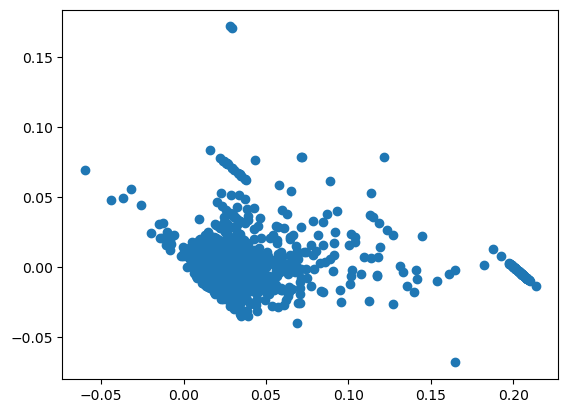

In [56]:
residuals = y_test-y_predict
plt.scatter(y_predict,residuals)
plt.show()

In [57]:
model.named_steps['linear'].coef_

array([-9.95602077e-04,  1.61411580e-07,  2.57944047e-04, -6.89468639e-07,
       -1.37713487e-04,  5.47149390e-07,  8.60693792e-01, -1.27318983e-04,
        5.77272142e-03,  7.98897379e-03, -3.66373598e-15,  3.76456923e-04,
        1.02406907e-03, -4.77562929e-03,  2.75372626e-04,  6.45581512e-03,
       -5.28861289e-04, -3.78233941e-04,  6.64458633e-04, -7.33886626e-04,
       -2.37956123e-03,  4.05339776e-04, -8.08726083e-04,  9.62422065e-04,
       -9.03819110e-05,  2.80706852e-04, -9.02504810e-04, -9.03329262e-04,
       -2.10497306e-04,  1.26697068e-03,  8.22202890e-04, -5.11678701e-04,
       -2.71893762e-04, -1.41717956e-03, -1.15247657e-03,  2.99382495e-03,
       -1.62181870e-03,  1.15901946e-03,  2.23324272e-03, -2.77924368e-03,
        3.38422666e-03, -1.85108941e-03,  1.18256842e-03,  6.36396356e-04,
       -2.18724005e-03, -3.62582262e-04,  7.42449165e-04,  4.19976458e-03,
       -1.46463308e-03, -3.73385942e-03, -1.74681673e-04,  3.64448719e-03,
       -1.28706578e-03,  

In [58]:
# Convert back from numpy arrays to data frames
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

## Ridge

In [59]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("Mean Squared Error:", mse)

Ridge(alpha=0.1)

R-squared: 0.847793033499308
Mean Squared Error: 0.0003544048094394468


## Forward stepwise selection to find the best subset of features

In [65]:
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

In [66]:
def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

'''def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)



def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))'''


'def cp(y_pred, y_true, n, d, sigma):\n    sigma2 = sigma**2\n    return (rss(y_pred, y_true) + 2*d*sigma2) / n\n\ndef aic(y_pred, y_true, n, d, sigma):\n    sigma2 = sigma**2\n    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)\n\n\n\ndef adj_r2(y_pred, y_true, n, d, sigma):\n    sigma2 = sigma**2\n    RSS = rss(y_pred, y_true)\n    TSS = tss(y_true)\n    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))'

In [67]:
def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

sigma = estimate_sigma(X_train_pd, y_train)

In [68]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator  

In [69]:
from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M0) with 1 features: ['BounceRates']
M0 subset score (3.): 1.2241171982719121
............
Best model (M1) with 2 features: ['BounceRates', 'Administrative']
M1 subset score (3.): 1.1321984173156296
............
Best model (M2) with 3 features: ['BounceRates', 'Administrative', 'ProductRelated']
M2 subset score (3.): 1.0931144210868404
............
Best model (M3) with 4 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType']
M3 subset score (3.): 1.0563853097735425
............
Best model (M4) with 5 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues']
M4 subset score (3.): 1.0397560131731711
............
Best model (M5) with 6 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2']
M5 subset score (3.): 1.0315673657213256
............
Best model (M6) with 7 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'Tr

............
Best model (M26) with 27 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSystems_Others', 'OperatingSystems_1', 'Browser_8']
M26 subset score (3.): 1.035513618493027
............
Best model (M27) with 28 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSyste

............
Best model (M39) with 40 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSystems_Others', 'OperatingSystems_1', 'Browser_8', 'Browser_1', 'Informational', 'TrafficType_20', 'TrafficType_10', 'Browser_5', 'Browser_Others', 'Region_4', 'Region_5', 'Month_Aug', 'Month_Jul', 'Browser_10', 'Region_8', 'Browser_6']
M39 subset score (3.): 1.0559118677106167
............
Best model (M40) with 41 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType

............
Best model (M52) with 53 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSystems_Others', 'OperatingSystems_1', 'Browser_8', 'Browser_1', 'Informational', 'TrafficType_20', 'TrafficType_10', 'Browser_5', 'Browser_Others', 'Region_4', 'Region_5', 'Month_Aug', 'Month_Jul', 'Browser_10', 'Region_8', 'Browser_6', 'Informational_Duration', 'Month_May', 'TrafficType_5', 'Browser_2', 'Month_Mar', 'Region_2', 'Administrative_Duration', 'TrafficType_11', 'Region_7', 'Region_6', 'Month_Oct', 'Browser_4', 'Weekend']
M52 subset score (3.): 1.0774859639960745
............
Best model (M53) with 54 features: ['BounceRates', 'Admi

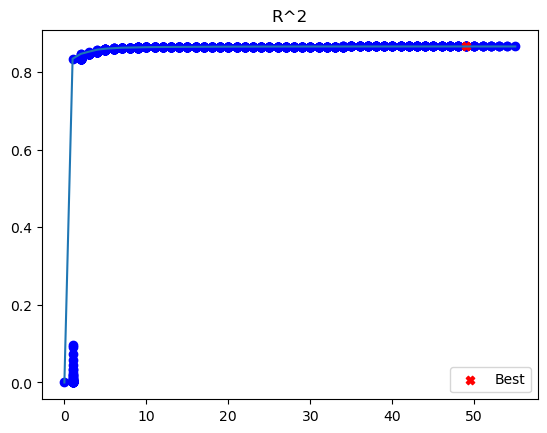

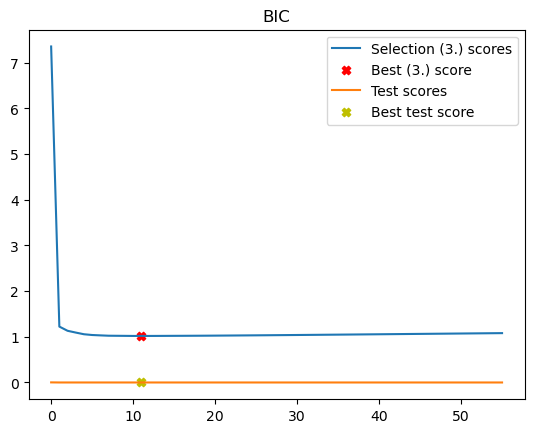

In [70]:
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="BIC",
                  verbose=True)

Now we try to search for the best polynomial model with our reduced set of features.

In [71]:
X_features_best = ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3']
X = training_set_no_missing[X_features_best].to_numpy()
y = training_set_no_missing['ExitRates'].to_numpy()

#splitting data
test_size = 0.2
test_seed = 50
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)


degree = list(range(1,5))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

X_train.shape  (5134, 11)
X_test.shape  (1284, 11)
Best degree:  2 
Val score:  0.8766889815952688
Test score: 0.8463873249470446


In [72]:
from sklearn.linear_model import Lasso
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('lasso', Lasso())  # Lasso estimator without specifying alpha
])

# Define the parameter grid to search for the best alpha value
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)  # cv specifies the number of cross-validation folds

# Fit the GridSearchCV object to the data (this will perform the cross-validation)
grid_search.fit(X_train, y_train)

# Access the best alpha value and best estimator
best_alpha = grid_search.best_params_['lasso__alpha']
best_estimator = grid_search.best_estimator_
# Print the best alpha value and best coefficients
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['lasso'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 0.01
Best coefficients: [ 0.00000000e+00 -2.29518683e-03 -1.20656001e-03  0.00000000e+00
 -6.14465420e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.89282133e-05  2.47942093e-05
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.66323049e-06  4.16096034e-04  3.42060741e-06 -0.00000000e+00
  3.37620411e-06 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.13410674e-05  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.39631202e-06 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00

In [77]:
best_degree = 2
best_alpha = 0.5  # Assuming you have the best alpha value from cross-validation

model = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('ridge', Lasso(alpha=best_alpha))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R-squared:", r2)
print("Mean Squared Error:", mse)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Lasso(alpha=0.5))])

R-squared: 0.014067087374027731
Mean Squared Error: 0.0022956857629620893


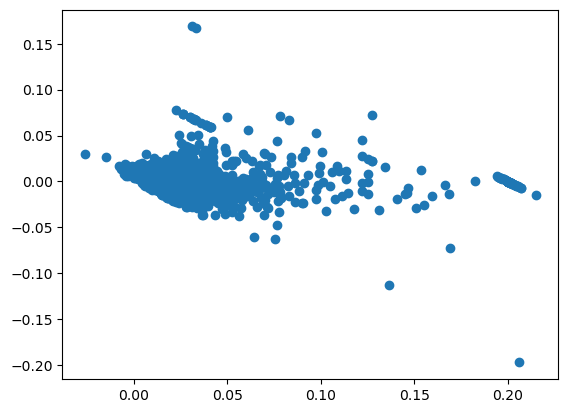

In [28]:
residuals = y_test-y_predict
plt.scatter(y_predict,residuals)
plt.show()

## Forward stepwise selection and crossvalidation

............
Best model (M0) with 1 features: ['BounceRates']
M0 subset score (3.): 0.8304605217081183
............
Best model (M1) with 2 features: ['BounceRates', 'Administrative']
M1 subset score (3.): 0.8434204393988033
............
Best model (M2) with 3 features: ['BounceRates', 'Administrative', 'ProductRelated']
M2 subset score (3.): 0.8491255163985041
............
Best model (M3) with 4 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType']
M3 subset score (3.): 0.8543938057380792
............
Best model (M4) with 5 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues']
M4 subset score (3.): 0.8568548601387838
............
Best model (M5) with 6 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2']
M5 subset score (3.): 0.8581235986429971
............
Best model (M6) with 7 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'Tr

............
Best model (M26) with 27 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSystems_Others', 'OperatingSystems_1', 'Browser_8']
M26 subset score (3.): 0.8611522978642545
............
Best model (M27) with 28 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSyst

............
Best model (M39) with 40 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSystems_Others', 'OperatingSystems_1', 'Browser_8', 'Browser_1', 'Informational', 'TrafficType_20', 'TrafficType_10', 'Browser_5', 'Browser_Others', 'Region_4', 'Region_5', 'Month_Aug', 'Month_Jul', 'Browser_10', 'Region_8', 'Browser_6']
M39 subset score (3.): 0.8603840927353105
............
Best model (M40) with 41 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType

............
Best model (M50) with 51 features: ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb', 'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSystems_Others', 'OperatingSystems_1', 'Browser_8', 'Browser_1', 'Informational', 'TrafficType_20', 'TrafficType_10', 'Browser_5', 'Browser_Others', 'Region_4', 'Region_5', 'Month_Aug', 'Month_Jul', 'Browser_10', 'Region_8', 'Browser_6', 'Informational_Duration', 'Month_May', 'TrafficType_5', 'Browser_2', 'Month_Mar', 'Region_2', 'Administrative_Duration', 'TrafficType_11', 'Region_7', 'Region_6', 'Month_Oct']
M50 subset score (3.): 0.8598665058195596
............
Best model (M51) with 52 features: ['BounceRates', 'Administrative', 'ProductRel

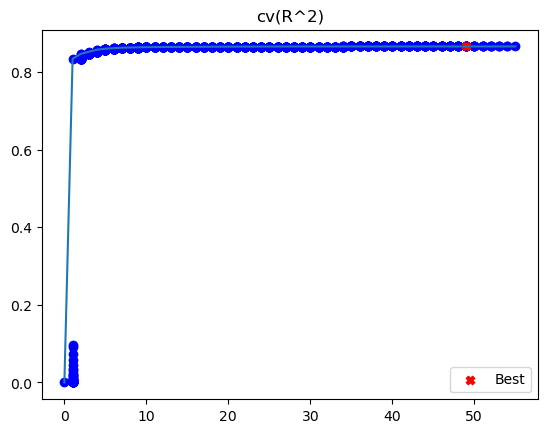

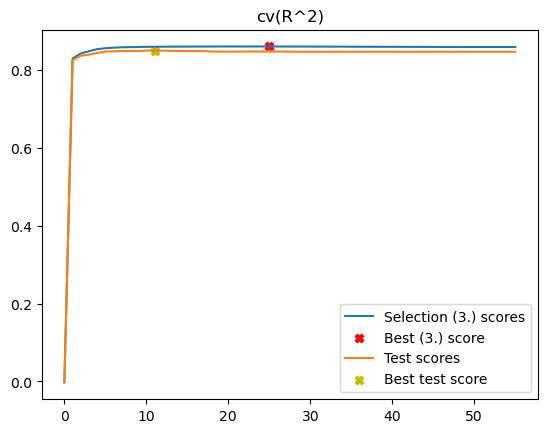

In [29]:
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=90)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator


cv = 10
sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score), cv=cv), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

In [ ]:
X_features_best = ['BounceRates', 'Administrative', 'ProductRelated', 'VisitorType', 'PageValues', 'TrafficType_2', 'OperatingSystems_2', 'TrafficType_4', 'Month_June', 'SpecialDay', 'OperatingSystems_3', 'TrafficType_Others', 'TrafficType_8', 'ProductRelated_Duration', 'TrafficType_13', 'TrafficType_3', 'TrafficType_1', 'Month_Feb',
                   'Month_Sep', 'Region_3', 'Region_1', 'Region_9', 'Month_Dec', 'Month_Nov', 'OperatingSystems_Others']
X = training_set_no_missing[X_features_best].to_numpy()
y = training_set_no_missing['ExitRates'].to_numpy()

#splitting data
test_size = 0.2
test_seed = 50
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)


degree = list(range(1,3))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

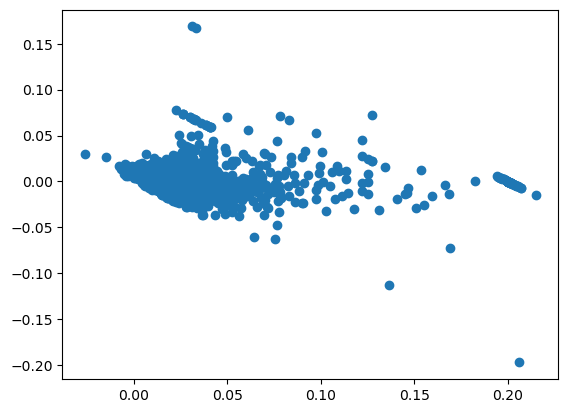

In [30]:
residuals = y_test-y_predict
plt.scatter(y_predict,residuals)
plt.show()